# Supervised image denoising
이미지에 포함된 noise를 제거하는 neural NW를 만들기

## Import libraries

In [390]:
import torch
import torchvision
from torch.utils.data import Dataset
from os import listdir
from os.path import join
from torchvision.transforms import Compose, ToTensor, ToPILImage, Resize, Lambda, Normalize, Grayscale
from torch.utils.data import DataLoader
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from math import log10
from tqdm.notebook import tqdm
import os

## Load data

In [391]:
from google.colab import drive
drive.mount('/content/drive')

directory_data  = '/content/drive/MyDrive/Machine_Learning/07/assignment_07_data.npz'
data            = np.load(directory_data)

train_data       = data['x_train'] #학습에 사용되는 깨끗한 이미지. train -> train_data 로 이름 내가 바꿈
train_noise = data['x_train_noise']#학습에 사용되는 깨끗한 이미지에 노이즈가 추가된 이미지

test_data        = data['x_test'] #테스트에 사용되는 깨끗한 이미지
test_noise  = data['x_test_noise']#테스트에 사용되는 깨끗한 이미지에 노이즈가 추가된 이미지

num_train   = train_data.shape[0]#학습 데이터의 수
num_test    = test_data.shape[0] #테스트 데이터의 수

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [392]:
print('*************************************************')
print('size of train :', train_data.shape) #학습 깨끗한 이미지 데이터는 10000개. 각 32by32임.
print('size of train_noise :', train_noise.shape) #학습 노이즈 포함 이미지 10000개. 각 32by32임.
print('*************************************************')
print('size of test :', test_data.shape)#테스트 깨끗한 이미지 데이터는 5000개. 각 32by32임.
print('size of test_noise :', test_noise.shape)#테스트  노이즈 포함  이미지 데이터는 5000개. 각 32by32임.
print('*************************************************')

*************************************************
size of train : (10000, 32, 32)
size of train_noise : (10000, 32, 32)
*************************************************
size of test : (5000, 32, 32)
size of test_noise : (5000, 32, 32)
*************************************************


## plot examples of the data

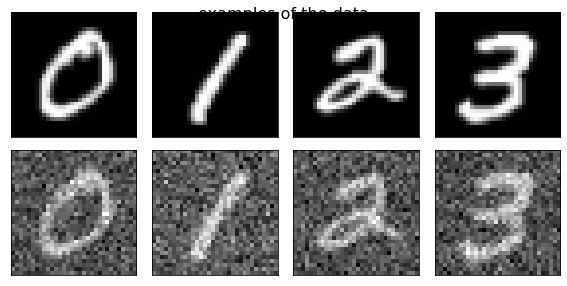

In [393]:
nRow = 2
nCol = 4
size = 2

title       = 'examples of the data'
fig, axes   = plt.subplots(nRow, nCol, figsize=(size * nCol, size * nRow))
fig.suptitle(title, fontsize=16)

for c in range(nCol):

    axes[0, c].imshow(train_data[c * 1000], cmap='gray')
    axes[1, c].imshow(train_noise[c * 1000], cmap='gray')

    axes[0, c].xaxis.set_visible(False)
    axes[1, c].xaxis.set_visible(False)
    
    axes[0, c].yaxis.set_visible(False)
    axes[1, c].yaxis.set_visible(False)

plt.tight_layout()
plt.show()

## custom data loader for the PyTorch framework

In [394]:
#위에서 로드한 데이터를 파이토치에서 사용하기 위한 함수. 변경하지 말것
class dataset(Dataset):
    
    def __init__(self, image, image_noise):
        
        self.image          = image
        self.image_noise    = image_noise
    
    def __getitem__(self, index):
        
        image       = self.image[index]
        image_noise = self.image_noise[index]

        image       = torch.FloatTensor(image).unsqueeze(dim=0)
        image_noise = torch.FloatTensor(image_noise).unsqueeze(dim=0)

        return (image, image_noise)
    
    def __len__(self):

        number_image = self.image.shape[0]

        return number_image

## setting device

In [395]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') #cpu 쓸거면 else 문의 mps 대신 cpu로 바꾸기

In [396]:
print(device)

cuda


## construct datasets and dataloaders for training and testing

In [397]:
# ================================================== 
# determine your own parameter value
#
size_minibatch      = 50 #알아서 수정
#
# ================================================== 

dataset_train       = dataset(train_data, train_noise) #clean image 와 노이즈 포함된 이미지가 짝으로 들어있음
dataset_test        = dataset(test_data, test_noise) #clean image 와 노이즈 포함된 이미지가 짝으로 들어있음

#미니배치보다 적은 수의 데이터가 남아있으면 버림(drop last=true)
dataloader_train    = torch.utils.data.DataLoader(dataset_train, batch_size=size_minibatch, shuffle=True, drop_last=True)
dataloader_test     = torch.utils.data.DataLoader(dataset_test, batch_size=size_minibatch, shuffle=True, drop_last=True)

## shape of the data when using the data loader

In [398]:
train_image, train_image_noise = next(iter(dataloader_train))
test_image, test_image_noise = next(iter(dataloader_test))

In [399]:
#두번째 인자 1 은 채널임. (파이토치는 nnw의 인픗으로 줄 때 채널의 수를 줌)
# 인자: mini-batch-size x channel x height x width
print('************************************************************')
print('size of mini-batch of the training image:', train_image.shape) #iteration마다 로딩되는 데이터의 사이즈.(미니배치의 사이즈와 동일)
print('************************************************************')
print('size of mini-batch of the training image_noise:', train_image_noise.shape)
print('************************************************************')
print('size of mini-batch of the testing image:', test_image.shape)
print('************************************************************')
print('size of mini-batch of the testing image_noise:', test_image_noise.shape)
print('************************************************************')

************************************************************
size of mini-batch of the training image: torch.Size([50, 1, 32, 32])
************************************************************
size of mini-batch of the training image_noise: torch.Size([50, 1, 32, 32])
************************************************************
size of mini-batch of the testing image: torch.Size([50, 1, 32, 32])
************************************************************
size of mini-batch of the testing image_noise: torch.Size([50, 1, 32, 32])
************************************************************


## construct a neural network 

In [400]:
# ================================================== 
# define your own neural network architecture and initialization
#
class Network(nn.Module):
    def __init__(self):
        super(Network,self).__init__()

        # -------------------------------------------------
        # Encoder (문제에 주어진 함수들만 사용하여 자유롭게 변경하기.channel의 수, layer의 수 변경가능. 
        #(activation function(=ReLU ?),BatchNorm2d 을 사용하든 말든 알아서. )
        # -------------------------------------------------
        self.encoder_layer1 = nn.Sequential(
            #convolution을 수행. input channel=1 , outputchannel=2. 내가 채널 수는 자유롭게 수정하면 됩.
            nn.Conv2d(in_channels=1, out_channels=2, kernel_size=3, stride=1, padding=1, bias=True),  
            nn.MaxPool2d(2,2), #2by2커널의 맥시멈 값만 가져옴. 그래서 사이즈가 반으로 줄음
            nn.ReLU(),# 액티베이션 함수
            nn.BatchNorm2d(2), #feature들의 값을 normalize함.= batch normalization. 이때 인자는 outputchannel의 수와 동일해야 함.(8로 오타있었음)
        )
        
        self.encoder_layer2 = nn.Sequential(
            #위의 아웃풋이 인풋의 숫자로 들어감. output channel도 자유롭게 수정하기. 
            nn.Conv2d(in_channels=2, out_channels=4, kernel_size=3, stride=1, padding=1, bias=True),
            nn.MaxPool2d(2,2), #이미지 사이즈를 반으로,.
            nn.ReLU(),
            nn.BatchNorm2d(4),#이 사이즈는 위의 outputchannel의 수와 동일해야 함.(16으로 오타있었음)
        )

        # -------------------------------------------------
        # Decoder
        # -------------------------------------------------
        self.decoder_layer2 = nn.Sequential(
            #bilinear을 사용한다는 말은 데이터의 사이즈를 두배로 키운다는 뜻.
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
            # 
            nn.Conv2d(in_channels=4, out_channels=2, kernel_size=3, stride=1, padding=1, bias=True),
            nn.ReLU(),
            nn.BatchNorm2d(2), #위 out_channels과 동일한 숫자여야 함 (오타 8)
        )
        
        self.decoder_layer1 = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
            # 마지막 Conv2d에서 out_channels의 수는 무조건 1이어야 함
            nn.Conv2d(in_channels=2, out_channels=1, kernel_size=3, stride=1, padding=1, bias=True),
            nn.Sigmoid(), #activation function. output값이 0~1사이가 되도록 제한함.
        )

        # -------------------------------------------------
        # Network
        # -------------------------------------------------
        self.network = nn.Sequential(
            self.encoder_layer1,
            self.encoder_layer2,
            self.decoder_layer2, 
            self.decoder_layer1,
        )

        self.initialize_weight()# 바로 아래 정의 있음.

    def forward(self,x):
    
        out = self.network(x)
      
        return out

    # ======================================================================
    # initialize weights #여기도 자유롭게 수정
    # ======================================================================
    def initialize_weight(self):
            
        for m in self.network.modules():
            
            if isinstance(m, nn.Conv2d):

                nn.init.xavier_uniform_(m.weight) #성능에 맞춰서 내가 알아서 다양한 initialization 함수를 사용하면 됨
                if m.bias is not None:

                    nn.init.constant_(m.bias, 1)
                    pass
                    
            elif isinstance(m, nn.BatchNorm2d):
                
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 1)
                
            elif isinstance(m, nn.Linear):

                nn.init.xavier_uniform_(m.weight)

                if m.bias is not None:
                    
                    nn.init.constant_(m.bias, 1)
                    pass
#
# ================================================== 

## build the network

In [401]:
# ================================================== 
# determine your own parameter value
# 알아서 수정
learning_rate   = 0.001
weight_decay    = 0.001
number_epoch    = 200
#
# ================================================== 

model       = Network().to(device) #gpu,cpu로 옮김
optimizer   = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

## compute the prediction

In [402]:
def compute_prediction(model, input):

    prediction = model(input)

    return prediction

## compute the loss
- use the mean squared error for the loss
- use the following loss function `nn.MSELoss()`
- input dimension: mini-batch-size x channel x height x width

In [403]:
def compute_loss(prediction, original):
    # ================================================== 
    # fill up the blank
    # noise data가 input으로 들어왔을 때 prediction 과 progimal image와의 mean square error을 파이토치의 msdloss로 계산
    criterion = nn.MSELoss() 
    loss = criterion(prediction, original)
    #
    # ================================================== 

    return loss

## compute the loss value

In [404]:
def compute_loss_value(loss):
    
    loss_value = loss.item() #loss의 값을 실제 스케일로 얻음
    
    return loss_value

## compute the PSNR metric

- input dimension: mini-batch-size x channel x height x width
- psnr is defined by $10 * \log_{10}(\frac{1}{\textrm{MSE}})$
- MSE is defined by $\textrm{MSE}(x, y) = \frac{1}{n} \| x - y \|_2^2$ where $n$ is the length of data $x$ and $y$

In [405]:
def compute_psnr(data1, data2):

    mse         = nn.MSELoss()(data1, data2)
    mse_value   = mse.item() 
    psnr        = 10 * np.log10(1 / mse_value)

    return psnr

## Variable for the learning curves

In [406]:
#epoch마다저장
loss_train_mean = np.zeros(number_epoch)# train loss의 mean
loss_train_std  = np.zeros(number_epoch)
psnr_train_mean = np.zeros(number_epoch)
psnr_train_std  = np.zeros(number_epoch)

loss_test_mean  = np.zeros(number_epoch)
loss_test_std   = np.zeros(number_epoch)
psnr_test_mean  = np.zeros(number_epoch)
psnr_test_std   = np.zeros(number_epoch)

## train

In [407]:
def train(model, optimizer, dataloader):

    loss_epoch      = []
    psnr_epoch      = []

    model.train() #train  model로 사용해야 함,

    #image = clean image, image_noise=noise가 포함된 image. dataloader=training data
    for index_batch, (image, image_noise) in enumerate(dataloader):
        #mj: image 는 미니배치 내에서의 data
        #device로 옮겨줌
        image       = image.to(device)
        image_noise = image_noise.to(device)
        
        # ================================================== 
        # fill up the blank
        #       
        train_pred = compute_prediction(model, image_noise)
        loss        = compute_loss(train_pred,image)#loss object가 결과로 나옴
        loss_value  = compute_loss_value(loss) # loss의 scaler값을구하기 
        psnr        = compute_psnr(train_pred,image)
        #
        # ================================================== 

        loss_epoch.append(loss_value)#얻은 값 추가
        psnr_epoch.append(psnr)

        # ================================================== 
        # fill up the blank (update moodel parameters)
        #  구한 값으로 model parameter을 업데이트.    
        # optimizer을 통해 nnw를 loss를 통해 업데이트 하기.
        optimizer.zero_grad()
        loss.backward()   # backpropagate the loss. Require_grad=True로 설정된 모든 텐서들에 대해 gradient를 계산한다.
        optimizer.step()        # adjust parameters based on the calculated gradients.= 경사하강법(gradient descent)


        #
        # ==================================================  
    
    #mini batch마다의 loss의 mean,std...등을 저장해서 return 함.
    loss_mean   = np.mean(loss_epoch)
    loss_std    = np.std(loss_epoch)

    psnr_mean   = np.mean(psnr_epoch)
    psnr_std    = np.std(psnr_epoch)

    return (loss_mean, loss_std, psnr_mean, psnr_std)    

## test

In [408]:
#위의 train 코드와 (update moodel parameters) 부분이 없는것 빼고 완전히 동일함.
def test(model, dataloader):

    loss_epoch      = []
    psnr_epoch      = []

    model.eval() #eval  model로 사용해야 함,

    #dataloader = testing data,
    for index_batch, (image, image_noise) in enumerate(dataloader):#각 minibatch마다의 정보 구하기
    
        image       = image.to(device)
        image_noise = image_noise.to(device)

        # ================================================== 
        # fill up the blank
        #     
        prediction = compute_prediction(model, image_noise)  #내가 추가함
        loss        = compute_loss(prediction,image)
        loss_value  = compute_loss_value(loss) # loss의 scaler값을구하기 
        psnr        = compute_psnr(prediction,image)

        #
        # ================================================== 

        loss_epoch.append(loss_value)
        psnr_epoch.append(psnr)

    loss_mean   = np.mean(loss_epoch)
    loss_std    = np.std(loss_epoch)
 
    psnr_mean   = np.mean(psnr_epoch)
    psnr_std    = np.std(psnr_epoch)

    return (loss_mean, loss_std, psnr_mean, psnr_std)

## train and test

In [ ]:
#실제 potimization 과정.
# ================================================================================
# 
# iterations for epochs
#
# ================================================================================
for i in tqdm(range(number_epoch)):
    
    # ================================================================================
    # 
    # training
    #
    # ================================================================================
    #수정 x
    #위에서 정의한 train함수를 사용하여 dataloader로 epoch마다의 loss, psnr값들을 얻어 넣어줌
    (loss_train_mean_epoch, loss_train_std_epoch, psnr_train_mean_epoch, psnr_train_std_epoch) = train(model, optimizer, dataloader_train)
    loss_train_mean[i]  = loss_train_mean_epoch
    loss_train_std[i]   = loss_train_std_epoch

    psnr_train_mean[i]  = psnr_train_mean_epoch
    psnr_train_std[i]   = psnr_train_std_epoch

    # ================================================================================
    # 
    # testing
    #
    # ================================================================================
    #수정 x
    #dataloader로 epoch마다의 loss, psnr값들을 얻어 넣어줌
    (loss_test_mean_epoch, loss_test_std_epoch, psnr_test_mean_epoch, psnr_test_std_epoch) = test(model, dataloader_test)

    loss_test_mean[i]   = loss_test_mean_epoch
    loss_test_std[i]    = loss_test_std_epoch

    psnr_test_mean[i]   = psnr_test_mean_epoch
    psnr_test_std[i]    = psnr_test_std_epoch

  0%|          | 0/200 [00:00<?, ?it/s]

---

## functions for presenting the results

---

In [ ]:
def function_result_01():
    
    title           = 'loss (training)'
    label_axis_x    = 'epoch' 
    label_axis_y    = 'loss'
    color_mean      = 'red'
    color_std       = 'blue'
    alpha           = 0.3

    plt.figure(figsize=(8, 6))
    plt.title(title)

    plt.plot(range(len(loss_train_mean)), loss_train_mean, '-', color = color_mean)
    plt.fill_between(range(len(loss_train_mean)), loss_train_mean - loss_train_std, loss_train_mean + loss_train_std, facecolor = color_std, alpha = alpha) 
    
    plt.xlabel(label_axis_x)
    plt.ylabel(label_axis_y)

    plt.tight_layout()
    plt.show()

In [ ]:
def function_result_02():
    
    title           = 'loss (testing)'
    label_axis_x    = 'epoch' 
    label_axis_y    = 'loss'
    color_mean      = 'red'
    color_std       = 'blue'
    alpha           = 0.3

    plt.figure(figsize=(8, 6))
    plt.title(title)

    plt.plot(range(len(loss_test_mean)), loss_test_mean, '-', color = color_mean)
    plt.fill_between(range(len(loss_test_mean)), loss_test_mean - loss_test_std, loss_test_mean + loss_test_std, facecolor = color_std, alpha = alpha) 
    
    plt.xlabel(label_axis_x)
    plt.ylabel(label_axis_y)

    plt.tight_layout()
    plt.show()

In [ ]:
def function_result_03():
    
    title           = 'psnr (training)'
    label_axis_x    = 'epoch' 
    label_axis_y    = 'psnr'
    color_mean      = 'red'
    color_std       = 'blue'
    alpha           = 0.3

    plt.figure(figsize=(8, 6))
    plt.title(title)

    plt.plot(range(len(psnr_train_mean)), psnr_train_mean, '-', color = color_mean)
    plt.fill_between(range(len(psnr_train_mean)), psnr_train_mean - psnr_train_std, psnr_train_mean + psnr_train_std, facecolor = color_std, alpha = alpha) 
    
    plt.xlabel(label_axis_x)
    plt.ylabel(label_axis_y)

    plt.tight_layout()
    plt.show()

In [ ]:
def function_result_04():
    
    title           = 'psnr (testing)'
    label_axis_x    = 'epoch' 
    label_axis_y    = 'psnr'
    color_mean      = 'red'
    color_std       = 'blue'
    alpha           = 0.3

    plt.figure(figsize=(8, 6))
    plt.title(title)

    plt.plot(range(len(psnr_test_mean)), psnr_test_mean, '-', color = color_mean)
    plt.fill_between(range(len(psnr_test_mean)), psnr_test_mean - psnr_test_std, psnr_test_mean + psnr_test_std, facecolor = color_std, alpha = alpha) 
    
    plt.xlabel(label_axis_x)
    plt.ylabel(label_axis_y)

    plt.tight_layout()
    plt.show()

In [ ]:
def function_result_05():

    nRow = 9
    nCol = 3
    size = 3 
    
    title = 'training results'
    fig, axes = plt.subplots(nRow, nCol, figsize=(size * nCol, size * nRow))
    fig.suptitle(title, fontsize=16)

    index_image = np.array([0, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000])

    image           = torch.FloatTensor(dataset_train.image[index_image]).unsqueeze(dim=1).to(device)
    image_noise     = torch.FloatTensor(dataset_train.image_noise[index_image]).unsqueeze(dim=1).to(device)
    image_denoise   = compute_prediction(model, image_noise)

    image           = image.detach().cpu().squeeze(axis=1)
    image_noise     = image_noise.detach().cpu().squeeze(axis=1)
    image_denoise   = image_denoise.detach().cpu().squeeze(axis=1)

    nStep = 3
    
    for r in range(3):
        for c in range(nCol):

            axes[0 + r * nStep, c].imshow(image_noise[c + r * nStep], cmap='gray')
            axes[1 + r * nStep, c].imshow(image[c + r * nStep], cmap='gray', vmin=0, vmax=1)
            axes[2 + r * nStep, c].imshow(image_denoise[c + r * nStep], cmap='gray', vmin=0, vmax=1)

            axes[0 + r * nStep, c].xaxis.set_visible(False)
            axes[1 + r * nStep, c].xaxis.set_visible(False)
            axes[2 + r * nStep, c].xaxis.set_visible(False)
            
            axes[0 + r * nStep, c].yaxis.set_visible(False)
            axes[1 + r * nStep, c].yaxis.set_visible(False)
            axes[2 + r * nStep, c].yaxis.set_visible(False)

    plt.tight_layout()
    plt.show()

In [ ]:
def function_result_06():
    
    nRow = 9 
    nCol = 3
    size = 3
    
    title = 'testing results'
    fig, axes = plt.subplots(nRow, nCol, figsize=(size * nCol, size * nRow))
    fig.suptitle(title, fontsize=16)

    index_image     = np.array([0, 500, 1000, 1500, 2000, 2500, 3000, 3500, 4000])
    
    image           = torch.FloatTensor(dataset_test.image[index_image]).unsqueeze(dim=1).to(device)
    image_noise     = torch.FloatTensor(dataset_test.image_noise[index_image]).unsqueeze(dim=1).to(device)
    image_denoise   = compute_prediction(model, image_noise)

    image           = image.detach().cpu().squeeze(axis=1)
    image_noise     = image_noise.detach().cpu().squeeze(axis=1)
    image_denoise   = image_denoise.detach().cpu().squeeze(axis=1)

    nStep = 3

    for r in range(3):
        for c in range(nCol):

            axes[0 + r * nStep, c].imshow(image_noise[c + r * nStep], cmap='gray')
            axes[1 + r * nStep, c].imshow(image[c + r * nStep], cmap='gray', vmin=0, vmax=1)
            axes[2 + r * nStep, c].imshow(image_denoise[c + r * nStep], cmap='gray', vmin=0, vmax=1)

            axes[0 + r * nStep, c].xaxis.set_visible(False)
            axes[1 + r * nStep, c].xaxis.set_visible(False)
            axes[2 + r * nStep, c].xaxis.set_visible(False)
            
            axes[0 + r * nStep, c].yaxis.set_visible(False)
            axes[1 + r * nStep, c].yaxis.set_visible(False)
            axes[2 + r * nStep, c].yaxis.set_visible(False)

    plt.tight_layout()
    plt.show()

In [ ]:
def function_result_07():
    
    print('final training psnr = %9.8f' % (psnr_train_mean[-1]))

In [ ]:
def function_result_08():
    
    print('final testing psnr = %9.8f' % (psnr_test_mean[-1]))

---

## results 

---

In [ ]:
number_result = 8

for i in range(number_result):

    title           = '# RESULT # {:02d}'.format(i+1) 
    name_function   = 'function_result_{:02d}()'.format(i+1)

    print('') 
    print('################################################################################')
    print('#') 
    print(title)
    print('#') 
    print('################################################################################')
    print('') 

    eval(name_function)